## Assignemnt 6- Part A: Autograd Implementation

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.utils import np_utils
from scipy.special import softmax

np.random.seed(0)

#Define Autograd class

In [ ]:
# Define the class Tensor
class Tensor (object):
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None

        if(id is None):
            self.id = np.random.randint(0,1000000000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = FloatTensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    return
                    print(self.id)
                    print(self.creation_op)
                    print(len(self.creators))
                    for c in self.creators:
                        print(c.creation_op)
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if self.creation_op == "softmax":
                    self.creators[0].backward(self.grad)

                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):
        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def shape(self):
      return self.data.shape
    
    def softmax(self):
        x = self.data - self.data.max(axis=1, keepdims=True)
        y = np.exp(x)
        v = y / y.sum(axis=1, keepdims=True)

        if(self.autograd):
            return Tensor(v,
                          autograd=True,
                          creators=[self],
                          creation_op="softmax")
        return Tensor(v)

    def cross_entropy(self, target_indices):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)
        
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  


#Unit Tests

##Add

In [ ]:
def add():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  c = a + b
  c.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  np.testing.assert_array_equal(a.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(b.grad.data, [1, 1, 1, 1, 1])

##Subtraction

In [ ]:
def sub():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  c = a - b
  c.backward(Tensor(np.array([1, 1, 1, 1, 1])))
  
  np.testing.assert_array_equal(a.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(b.grad.data, [-1, -1, -1, -1, -1])

##Multiplication

In [ ]:
def mul():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  e = a * b
  e.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  np.testing.assert_array_equal(a.grad.data, [2, 2, 2, 2, 2])
  np.testing.assert_array_equal(b.grad.data, [1, 2, 3, 4, 5])

#Loading MNIST dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from sklearn.metrics import mean_squared_error
import itertools
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Data Visualization

In [ ]:
def visualize__dataset(dataset, N, name):
  print("Visualizing the " + name + " dataset.")
  fig = plt.figure(figsize=plt.figaspect(0.3))

  for image in range(0, N):
    ax = fig.add_subplot(1, 10, image+1)
    ax.imshow(dataset[image], cmap='Accent')

Visualizing the train dataset.


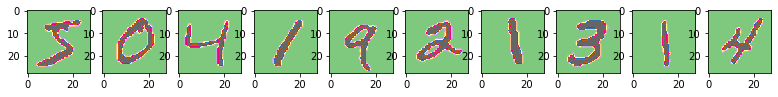

In [ ]:
n = 10
visualize__dataset(X_train, n, "train")

In [ ]:
from keras.utils import np_utils

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28*28) / 255.
X_test = X_test.reshape(X_test.shape[0], 28*28) / 255.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
X_train = X_train[:10]
y_train = y_train[:10]
X_test = X_test[:100]
y_test = y_test[:100]
input_dim = X_train.shape[1]
num_classes = y_test.shape[1]

#Train Classifier

In [ ]:
data = Tensor(X_train, autograd=True)
expected = Tensor(y_train, autograd=True)

weights = []
weights.append(Tensor(np.random.rand(input_dim, 64), autograd=True))
weights.append(Tensor(np.random.rand(64, 10), autograd=True))
learning_rate = 0.0001
 
for i in range(10):

  predicted = data.mm(weights[0]).mm(weights[1]).softmax()
  loss = ((predicted - expected) * (predicted - expected)).sum(0)
  loss.backward(Tensor(np.ones_like(loss.data)))
  for wts in weights:
    wts.data -= wts.grad.data*learning_rate
    wts.grad.data = wts.grad.data*0
    print(np.mean(loss.data))

1.599465657533295
1.599465657533295
1.6541062867850265
1.6541062867850265
1.7765837817684642
1.7765837817684642
1.7999999999157268
1.7999999999157268
1.4000000000030013
1.4000000000030013
1.7812403419274634
1.7812403419274634
1.7999577946503098
1.7999577946503098
1.6
1.6
1.7203136364865
1.7203136364865
1.6404982125161751
1.6404982125161751
